In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

np.set_printoptions(precision=6, suppress=True) 
delta_rel = np.array([0.001, 0.001, 0.0005, 0.001])

### Исходных данные

In [ ]:
def f(x):
    x1, x2, x3, x4 = x
    return x1/x2**2 + x2/x3**2 + x4/x1**2

datasets = [
    # Набор 1
    {
        "x": np.array([1.0, 2.0, 3.0, 4.0]),
        "delta_rel": delta_rel,
        "name": "Набор 1"
    },
    # Набор 2
    {
        "x": np.array([2.0, 1.5, 2.5, 3.5]),
        "delta_rel": delta_rel,
        "name": "Набор 2"
    },
    # Набор 3
    {
        "x": np.array([1.2, 2.2, 3.1, 3.9]),
        "delta_rel": delta_rel,
        "name": "Набор 3"
    }
]

### Метод линеаризации

In [ ]:
def linearization_method(f, xvec, delta_rel):
    x = np.array(xvec, dtype=float)
    Delta = delta_rel * x  # Абсолютные погрешности
    
    # Расчет частных производных
    derivatives = []
    for i in range(len(x)):
        h = 1e-6 * x[i]  # Шаг для численного дифференцирования
        x_forward = x.copy()
        x_backward = x.copy()
        x_forward[i] += h
        x_backward[i] -= h
        df_dxi = (f(x_forward) - f(x_backward)) / (2 * h)
        derivatives.append(df_dxi)
    
    derivatives = np.array(derivatives)
    contributions = np.abs(derivatives) * Delta
    Delta_y = np.sum(contributions)
    
    return Delta_y, derivatives, Delta, contributions

### Метод Монте-Карло

In [17]:
def monte_carlo_method(f, xvec, delta_rel, N=100000):
    x = np.array(xvec, dtype=float)
    Delta = delta_rel * x
    y0 = f(x)
    
    # Генерация случайных значений
    random_samples = []
    for i in range(len(x)):
        # Равномерное распределение в пределах погрешности
        samples = np.random.uniform(x[i] - Delta[i], x[i] + Delta[i], N)
        random_samples.append(samples)
    
    # Вычисление y для всех комбинаций
    y_values = f(np.array(random_samples))
    
    # Максимальное отклонение
    Delta_y = np.max(np.abs(y_values - y0))
    
    return Delta_y

### Метод Крейновича

In [18]:
def kreinovich_method(f, xvec, delta_rel, N=300, k=0.01):
    x = np.array(xvec, dtype=float)
    Delta = delta_rel * x
    d_i = k * Delta
    y0 = f(x)
    
    # Генерация значений из распределения Коши
    random_samples = []
    for i in range(len(x)):
        # Распределение Коши
        samples = np.random.standard_cauchy(size=N) * d_i[i] + x[i]
        random_samples.append(samples)
    
    # Вычисление y и отклонений
    y_values = f(np.array(random_samples))
    dy = y_values - y0
    
    # Уравнение для оценки параметра масштаба
    def equation_for_d(d, dy_array):
        return np.sum(d**2 / (dy_array**2 + d**2)) - len(dy_array)/2
    
    # Решение уравнения
    d_hat, = fsolve(equation_for_d, 0.001, args=(dy,))
    Delta_y = np.abs(d_hat) / k
    
    return Delta_y

### Расчеты для всех трех наборов данных

In [ ]:
results = []

for dataset in datasets:
    print(f"\n{dataset['name']}: x = {dataset['x']}")
    
    # Вычисление номинального значения
    y0 = f(dataset['x'])
    print(f"y0 = f(x) = {y0:.6f}")
    
    # Метод линеаризации
    Delta_y_lin, derivatives, Delta, contributions = linearization_method(f, dataset['x'], dataset['delta_rel'])
    
    # Метод Монте-Карло
    Delta_y_mc = monte_carlo_method(f, dataset['x'], dataset['delta_rel'], N=100000)
    
    # Метод Крейновича
    Delta_y_krey = kreinovich_method(f, dataset['x'], dataset['delta_rel'], N=300, k=0.01)
    
    # Сохраняем результаты
    results.append({
        'name': dataset['name'],
        'x': dataset['x'],
        'y0': y0,
        'lin': Delta_y_lin,
        'mc': Delta_y_mc,
        'krey': Delta_y_krey,
        'derivatives': derivatives,
        'contributions': contributions
    })
    
    # Вывод результатов
    print(f"Метод линеаризации:    Δy = {Delta_y_lin:.8f} (δy = {Delta_y_lin/y0*100:.4f}%)")
    print(f"Метод Монте-Карло:     Δy = {Delta_y_mc:.8f} (δy = {Delta_y_mc/y0*100:.4f}%)")
    print(f"Метод Крейновича:      Δy = {Delta_y_krey:.8f} (δy = {Delta_y_krey/y0*100:.4f}%)")
    
    # Разница между методами
    diff_mc_lin = abs(Delta_y_mc - Delta_y_lin) / Delta_y_lin * 100
    diff_krey_lin = abs(Delta_y_krey - Delta_y_lin) / Delta_y_lin * 100
    print(f"\nОтносительная разница от линеаризации:")
    print(f"  Монте-Карло: {diff_mc_lin:.2f}%")
    print(f"  Крейновича:  {diff_krey_lin:.2f}%")

СРАВНЕНИЕ ТРЕХ МЕТОДОВ ОЦЕНКИ ПОГРЕШНОСТИ

Набор 1: x = [1. 2. 3. 4.]
y0 = f(x) = 4.472222
Метод линеаризации:    Δy = 0.01225000 (δy = 0.2739%)
Метод Монте-Карло:     Δy = 0.01216232 (δy = 0.2720%)
Метод Крейновича:      Δy = 0.01211426 (δy = 0.2709%)

Относительная разница от линеаризации:
  Монте-Карло: 0.72%
  Крейновича:  1.11%

Набор 2: x = [2.  1.5 2.5 3.5]
y0 = f(x) = 2.003889
Метод линеаризации:    Δy = 0.00351389 (δy = 0.1754%)
Метод Монте-Карло:     Δy = 0.00334688 (δy = 0.1670%)
Метод Крейновича:      Δy = 0.00351740 (δy = 0.1755%)

Относительная разница от линеаризации:
  Монте-Карло: 4.75%
  Крейновича:  0.10%

Набор 3: x = [1.2 2.2 3.1 3.9]
y0 = f(x) = 3.185195
Метод линеаризации:    Δy = 0.00837293 (δy = 0.2629%)
Метод Монте-Карло:     Δy = 0.00816945 (δy = 0.2565%)
Метод Крейновича:      Δy = 0.00935834 (δy = 0.2938%)

Относительная разница от линеаризации:
  Монте-Карло: 2.43%
  Крейновича:  11.77%


### Визуализация результатов

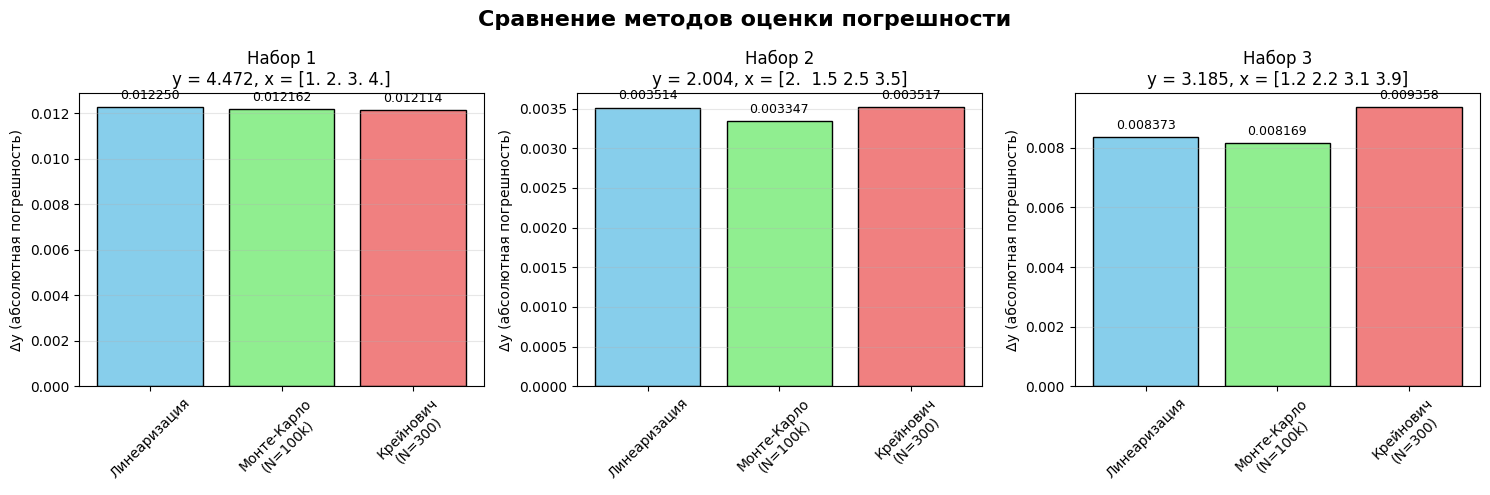

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Сравнение методов оценки погрешности', fontsize=16, fontweight='bold')

# Цвета для разных методов
colors = ['skyblue', 'lightgreen', 'lightcoral']
method_names = ['Линеаризация', 'Монте-Карло\n(N=100k)', 'Крейнович\n(N=300)']

for idx, result in enumerate(results):
    # Данные для текущего набора
    delta_values = [result['lin'], result['mc'], result['krey']]
    
    # График сравнения методов
    bars = axes[idx].bar(method_names, delta_values, color=colors, edgecolor='black')
    axes[idx].set_title(f"{result['name']}\ny = {result['y0']:.3f}, x = {result['x']}")
    axes[idx].set_ylabel('Δy (абсолютная погрешность)')
    axes[idx].grid(True, alpha=0.3, axis='y')
    axes[idx].tick_params(axis='x', rotation=45)
    
    # Добавление значений на столбцы
    for bar, value in zip(bars, delta_values):
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height * 1.02,
                      f'{value:.6f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()